In [760]:
# import needed lib
import os
import random
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import joblib
from keras.layers import BatchNormalization, Dropout, Bidirectional, Layer, Rescaling
from keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

In [134]:
CUR_DIR = os.getcwd()

In [816]:
# read all the captcha 
def load_data(file_path):
    n_samples = len(os.listdir(file_path))
    imgs = []
    labels = []

    # read from the directory
    for i, img in enumerate(os.listdir(file_path)):
        if (i == 100):
            break
        imgs.append(cv2.resize(cv2.imread(os.path.join(file_path, img), 0), (300, 60)))
        labels.append(img[0:-6])

    return np.array(imgs), labels

    # # print the ddtype
    # print(X[0].dtype) # uint8

    # # preprocess the image
    # for i in range(len(X)):
    #     X[i] = cv2.resize(X[i], (300, 57)) # reshape it to the same size
    #     X[i] = cv2.equalizeHist(X[i]) # increase the contrast of the img
    #     # X[i] = cv2.medianBlur(X[i], (2)) # try to remove noise term

In [138]:
def preprocess_data(imgs):
    processed_data = imgs
    return processed_data

In [688]:
from sklearn.model_selection import train_test_split
def split_data(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_val, y_train, y_val

In [640]:
from sklearn.preprocessing import LabelEncoder
# Encode labels as sequences of integers
def encode_labels(labels, max_timesteps):
    label_encoder = LabelEncoder()
    label_encoder.fit(list("ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789-()"))  # All possible characters
    encoded_labels = [label_encoder.transform(list(label)) for label in labels]
    padded_labels = np.array([
        np.pad(l, (0, max_timesteps - len(l)), 
               mode='constant', constant_values=-1)
        for l in encoded_labels
    ])
    joblib.dump(label_encoder, 'label_encoder.pkl')  # Save to file
    return padded_labels, label_encoder

In [820]:
# CTC loss function
def ctc_loss(y_true, y_pred):
    print('[DEBUG] start ctc_loss')
    tf.config.run_functions_eagerly(True)  # Temporary debug
    print(f'[DEBUG] shape: y_true {y_true.shape}, y_pred {y_pred.shape}')

    # Get the batch size and sequence length
    batch_size = tf.shape(y_pred)[0]
    seq_length = tf.shape(y_pred)[1]
    
    # Calculate input length (same for all samples)
    input_length = tf.fill([batch_size], seq_length)  # [259, 259,...]
    
    # Calculate label length (count non-padded tokens)
    label_length = tf.reduce_sum(tf.cast(y_true != -1, tf.int32), axis=1)
    
    # Convert types for CTC
    y_true = tf.cast(y_true, tf.int32)
    input_length = tf.cast(input_length, tf.int32)
    label_length = tf.cast(label_length, tf.int32)

    # Reshape tensors for CTC
    y_true = tf.reshape(y_true, [batch_size, -1])  # Ensure 2D
    input_length = tf.reshape(input_length, [batch_size, 1])
    label_length = tf.reshape(label_length, [batch_size, 1])

    # print(f'[DEBUG] shape: y_true {y_true.shape}, y_pred: {y_pred.shape}')
    # print(f'[DEBUG] batch_size: {batch_size}, input_length: {input_length}, label_length: {label_length}')

    # Add blank penalty
    blank_logit = y_pred[:, :, -1:]  # Get blank class probabilities
    blank_penalty = 0.01 * tf.reduce_mean(blank_logit)
            
    # Compute loss
    loss = keras.backend.ctc_batch_cost(
        y_true, y_pred,
        input_length=input_length,
        label_length=label_length
    ) + blank_penalty

    # batch_size = 16
    # input_length = tf.fill((batch_size, 1), tf.shape(y_pred)[1])
    # label_length = tf.fill((batch_size, 1), max_length)
    # loss = ctc_batch_cost(y_true, y_pred, input_length, label_length)

    return loss

In [888]:
class CTCMetrics(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, encoder, batch_size=32):
        super().__init__()
        self.validation_data = validation_data
        self.encoder = encoder
        self.batch_size = batch_size
        
    def on_epoch_end(self, epoch, logs=None):
        print('[DEBUG] start ctc metrics')
        x_val, y_val = self.validation_data
        total_samples = len(x_val)
        correct = 0

        test_img, test_label = x_val[0], y_val[0]
    
        # Visualize CNN features
        intermediate_model = Model(
            inputs=self.model.input,
            outputs=self.model.get_layer('input').output
        )
        features = intermediate_model.predict(test_img[np.newaxis,...])
        plt.imshow(features[0], aspect='auto')
        plt.title('input')
        plt.show()
        plt.close()
        
        intermediate_model = Model(
            inputs=self.model.input,
            outputs=self.model.get_layer('conv1').output
        )
        features = intermediate_model.predict(test_img[np.newaxis,...])
        for i in range(len(features[0])):
            if (i == 10):
                break
            plt.imshow(features[0][i].T, aspect='auto')
            plt.title(f'conv1{i}')
            plt.show()
            plt.close()
        

        # print(f"\n[DEBUG] y_val shape: {y_val.shape}, min/max: {y_val.min()}/{y_val.max()}")
            
        # Process in batches to avoid memory issues
        for i in range(0, total_samples, self.batch_size):
            batch_x = x_val[i:i+self.batch_size]
            batch_y = y_val[i:i+self.batch_size]
            
            # Predict
            y_pred = self.model.predict(batch_x, verbose=0)
            # print(f"[DEBUG] y_pred shape: {y_pred.shape}")
            
            # CTC decode
            input_length = np.ones(y_pred.shape[0]) * y_pred.shape[1]
            decoded, _ = tf.keras.backend.ctc_decode(
                y_pred,
                input_length=input_length,
                greedy=True
            )
            pred_indices = decoded[0].numpy()
            
            # Compare predictions with ground truth
            for true_seq, pred_seq in zip(batch_y, pred_indices):
                # Remove padding (-1) and decode
                true_chars = true_seq[true_seq != -1]
                pred_chars = pred_seq[pred_seq != -1]
                
                # Convert to text
                true_text = ''.join(self.encoder.inverse_transform(true_chars))
                pred_text = ''.join(self.encoder.inverse_transform(pred_chars))

                if (i < 5):
                    print(f"[INFO] True: '{true_text}' vs Pred: '{pred_text}'")
                    
                if true_text == pred_text:
                    correct += 1
        
        accuracy = correct / total_samples
        print(f"[INFO] Validation Accuracy: {accuracy:.4f}")
        logs['val_accuracy'] = accuracy  # Store for history

In [824]:
def train():
    # loading data
    imgs, labels = load_data("./data/train") # (10, 60, 300), (10)

    # # print the ddtype
    # print(imgs[0].dtype) # uint8
    
    # # print the original img
    # plt.figure(figsize=(8,8))
    # for i in range(len(imgs)):
    #     plt.subplot(5, 2, i+1)
    #     plt.imshow(imgs[i])
    #     plt.xlabel(f"{labels[i]}")
    # plt.show()

    # preprocess data
    processed_imgs = preprocess_data(imgs)

    # encode labels
    max_length = max(len(label) for label in labels)
    encoded_labels, encoder = encode_labels(labels, 37)
    # print(f'[DEBUG] shape: encoded_labels {encoded_labels.shape}')
    # print(f'[DEBUG] encoded_label: {encoded_labels[0]}')
    # unpadded = np.delete(encoded_labels[0], np.where(encoded_labels[0] == -1)[0])
    # print(f'[DEBUG] unpadded_label: {unpadded}')
    # decoded = encoder.inverse_transform(unpadded)
    # print(f'[DEBUG] decoded: {decoded} vs true: {labels[0]}')
    
    # Maximum length of any captcha in the dataset
    # max_length = max([len(label) for label in labels])
    # print(f'[DEBUG] max_length: {max_length}')
    
    # # Create a set of all unique characters in the labels
    # all_possible_characters = sorted(set("".join(labels)))
    # print(f'all_possible_characters: {all_possible_characters}')
    
    # # Create a mapping of characters to integers and integers to characters
    # char_to_int = {char: i for i, char in enumerate(all_possible_characters)}
    # int_to_char = {i: char for char, i in char_to_int.items()}

    # encoded_labels = [[char_to_int[char] for char in label] for label in labels]
    # encoded_labels_padded = np.array([
    #     np.pad(l, (0, 37 - len(l)), 
    #            mode='constant', constant_values=-1)
    #     for l in encoded_labels
    # ])
    
    # Reshape images for CNN input
    processed_imgs_reshape = processed_imgs.reshape(-1, 60, 300, 1)  # (batch_size, height, width, channels)

    # Create the model
    input_shape = (60, 300, 1)  # Input image shape (height, width, channels)
    num_classes = len(encoder.classes_)  # Number of unique characters
    # num_classes = len(all_possible_characters)
    model = create_fine_crnn(input_shape, num_classes)
    print(f'[DEBUG] Model output layer shape: {model.output_shape}')

    # Split the data
    X_train, X_val, y_train, y_val = split_data(processed_imgs, encoded_labels)

    # Reshape the data for training
    X_train = np.expand_dims(X_train, axis=-1)  # Shape becomes (8, 57, 300, 1)
    X_val = np.expand_dims(X_val, axis=-1)     # Shape becomes (2, 57, 300, 1)
    print(f'[DEBUG] shape: X_train: {X_train.shape}, X_val: {X_val.shape}')
    print(f'[DEBUG] shape: y_train: {y_train.shape}, y_val: {y_val.shape}')

    # Initialize with your actual data
    ctc_metrics = CTCMetrics(
        validation_data=(X_val, y_val),
        encoder=encoder
    )

    # 1. Get ACTUAL present classes (excluding padding -1)
    present_classes = np.unique(np.concatenate(y_train)[np.concatenate(y_train) != -1])
    num_present_classes = len(present_classes)
    
    # 2. Compute weights only for present classes
    class_weights = compute_class_weight(
        'balanced',
        classes=present_classes,  # Only use classes that exist in data
        y=np.concatenate(y_train)[np.concatenate(y_train) != -1]
    )
    
    # 3. Map to all possible classes (including unused ones)
    full_class_weights = np.full(num_classes + 1, 1e-5)  # +1 for blank token
    full_class_weights[present_classes] = class_weights
    
    # 4. Create weight dictionary
    class_weight_dict = dict(enumerate(full_class_weights))

    callbacks = [
        EarlyStopping(
            monitor='loss',
            patience=5,
            verbose=1,
            restore_best_weights=True),
        ctc_metrics,
    ]
    # Train with the callback
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=32,
        callbacks=callbacks
    )
    # model.fit(
    #     X_train, y_train,
    #     validation_data=(X_val, y_val),
    #     batch_size=8,  # Full batch training
    #     epochs=100,    # Needs many more epochs
    #     callbacks=[
    #     EarlyStopping(patience=5),
    #     ModelCheckpoint('best_model.h5')
    #     )
    
    # Save the model
    model.save("captcha_crnn_model.keras")

In [890]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, LSTM, Dense, Lambda

# Define the CNN + RNN model
def create_crnn(input_shape, num_classes):
    # Input layer
    input_layer = Input(shape=input_shape)

    # CNN layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Dynamic reshape for RNN
    conv_shape = x.shape  # Get (batch, height, width, channels)
    print(f'[DEBUG] conv_shape: {conv_shape}')
    timesteps = conv_shape[1] * conv_shape[2]
    features = conv_shape[3]
    x = Reshape((timesteps, features))(x)

    # RNN layers
    x = LSTM(128, return_sequences=True)(x)
    x = LSTM(64, return_sequences=True)(x)

    # Output layer
    output_layer = Dense(num_classes+1, activation='softmax')(x)  # +1 for CTC blank token

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

def create_fine_crnn(input_shape, num_classes):
    input_layer = Input(shape=input_shape, name='input')

    # Standardize values to be in the [0, 1] range
    x = Rescaling(1./255)(input_layer)
    
    # Transpose the tensor to shape (None, image_width, image_height, 1)
    x = Lambda(lambda x: tf.transpose(x, perm=[0, 2, 1, 3]), name="transpose")(x)
    
    # CNN 
    x = Conv2D(64, (3, 3), activation="relu", kernel_initializer=keras.initializers.he_normal(), padding="same", name='conv1')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), name='pool1')(x)

    x = Conv2D(128, (3, 3), activation="relu", kernel_initializer=keras.initializers.he_normal(), padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), name='pool2')(x)
    
    x = Conv2D(256, (3, 3), activation="relu", kernel_initializer=keras.initializers.he_normal(), padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 1), name='pool3')(x) # Pooling over time dimension

    # Reshape for RNN
    conv_shape = x.shape
    print(f'[DEBUG] conv_shape: {conv_shape}')
    timesteps = conv_shape[1]
    features = conv_shape[2] * conv_shape[3]
    x = Reshape((timesteps, features), name='reshape')(x)
    x = Dense(128, activation="relu", kernel_initializer=keras.initializers.he_normal())(x)
    x = Dropout(0.2)(x)

    # RNN
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = Dense(128, activation='relu')(x)  # Additional non-linear layer
    
    output_layer = Dense(num_classes+1, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    # Compile the model
    model.compile(optimizer='adam', loss=ctc_loss, metrics=['accuracy'])
    print(f'[INFO] Model Summary:\n{model.summary()}')
    return model

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        self.attention_dense = Dense(1, activation='tanh')
        super().build(input_shape)
    
    def call(self, x):
        # Compute attention scores
        attention_scores = self.attention_dense(x)  # Shape: (batch, timesteps, 1)
        
        # Apply softmax - using Keras softmax instead of tf.nn.softmax
        attention_weights = tf.keras.activations.softmax(attention_scores, axis=1)
        
        # Apply attention
        return x * attention_weights
    
    def compute_output_shape(self, input_shape):
        return input_shape

def create_enhanced_crnn(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # CNN Feature Extraction
    x = Conv2D(32, (3,3), padding='same', activation='relu', name='conv1')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(256, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((1,2), name='pool3')(x)  # Special pooling to preserve width
    x = Dropout(0.3)(x)
    
    # Prepare for RNN
    conv_shape = x.shape
    x = Reshape((conv_shape[1]*conv_shape[2], conv_shape[3]))(x)
    
    # Bidirectional RNN with Attention
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    
    # Attention (using the new layer)
    x = AttentionLayer()(x)
    
    # Output
    outputs = Dense(num_classes+1, activation='softmax')(x)
    
    return Model(inputs=inputs, outputs=outputs)

In [796]:
def load_model():
    # load keras model
    try:
        model_path = 'captcha_crnn_model.keras'  # or full path like 'models/your_model.keras'
        model = keras.models.load_model(model_path, 
                                        custom_objects={'ctc_loss': keras.backend.ctc_batch_cost})
        
        print("[INFO] Model loaded successfully!")
        print(f"[INFO] Model architecture:")
        model.summary()
        
    except FileNotFoundError:
        print(f"[ERROR] Error: File '{model_path}' not found. Check the path.")
    except Exception as e:
        print(f"[ERROR] Error loading model: {str(e)}")
        
    return model

def load_encoder():
    # load labal
    encoder = joblib.load('label_encoder.pkl')
    print('[INFO] Encoder loaded successfully!')
    return encoder

In [798]:
def decode_predictions(pred, encoder):
    pred_decoded, _ = keras.backend.ctc_decode(pred, input_length=[pred.shape[1]], greedy=True)
    pred_indices = pred_decoded[0].numpy()[0]
    valid_indices = pred_indices[pred_indices != -1]
    
    if len(valid_indices) == 0:
        return ""  # Return empty string if no valid predictions
    
    pred_chars = encoder.inverse_transform(valid_indices)
    return ''.join(pred_chars)

In [800]:
# Predict a CAPTCHA image
def predict_captcha(model, encoder, file_path):
    file_path = os.path.join(CUR_DIR, file_path)
    
    # print(f'[DEBUG] Current file path: {file_path}')
    
    n_samples = len(os.listdir(file_path))
    labels = []
    preds = []
    
    # print(f'[DEBUG] Number of samples: {n_samples}')

    # read from the directory
    for i, img in enumerate(os.listdir(file_path)):
        if (i == 1):
            break;
        img_read = cv2.resize(cv2.imread(os.path.join(file_path, img), 0), (300, 57))
        labels.append(img[0:-6])
        
        print('[DEBUG] Image sample and its label to be predict:')
        plt.figure(figsize=(8,8))
        plt.imshow(img_read)
        plt.title(f'{labels[0]}')
        plt.show()
        plt.close()  
    
        # # Preprocess the image
        img_reshaped = img_read.reshape(-1, 57, 300, 1)  # Reshape for model input
        print(f'[DEBUG] Image shape after preprocessing: {img_reshaped.shape}')
        
        # Predict the CAPTCHA
        print('[DEBUG] model prediction:')
        pred = model.predict(img_reshaped)
        final_text = decode_predictions(pred, encoder)
        preds.append(final_text)
        print(f'[DEBUG] prediction length: {len(final_text)}')
        print(f'[DEBUG] prediction: {final_text}')
    return labels, preds

In [802]:
def predict():
    # print(f'[DEBUG]{os.getcwd()}')
    model = load_model()
    encoder = load_encoder()
    labels, predicts = predict_captcha(model, encoder, "data/test")

[DEBUG] conv_shape: (None, 37, 15, 256)


Model: "functional_119"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 60, 300, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_23 (Rescaling)        │ (None, 60, 300, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transpose (Lambda)              │ (None, 300, 60, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 300, 60, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 300, 60, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 150, 30, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_267 (Conv2D)             │ (None, 150, 30, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ (None, 150, 30, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 75, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_268 (Conv2D)             │ (None, 75, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_97          │ (None, 75, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 37, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 37, 3840)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 37, 128)        │       491,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 37, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_36                │ (None, 37, 256)        │       263,168 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 37, 128)        │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 37, 66)         │         8,514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,167,682 (4.45 MB)

 Trainable params: 1,166,786 (4.45 MB)

 Non-trainable params: 896 (3.50 KB)

[INFO] Model Summary:
None
[DEBUG] Model output layer shape: (None, 37, 66)
[DEBUG] shape: X_train: (80, 60, 300, 1), X_val: (20, 60, 300, 1)
[DEBUG] shape: y_train: (80, 37), y_val: (20, 37)
Epoch 1/30


/opt/anaconda3/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


[DEBUG] start ctc_loss
[DEBUG] shape: y_true (32, 37), y_pred (32, 37, 66)
1/3 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - accuracy: 8.4459e-04 - loss: 134.2671[DEBUG] start ctc_loss
[DEBUG] shape: y_true (32, 37), y_pred (32, 37, 66)
2/3 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step - accuracy: 0.0011 - loss: 130.4968     [DEBUG] start ctc_loss
[DEBUG] shape: y_true (16, 37), y_pred (16, 37, 66)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0010 - loss: 127.1327[DEBUG] start ctc_loss
[DEBUG] shape: y_true (20, 37), y_pred (20, 37, 66)
[DEBUG] start ctc metrics
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


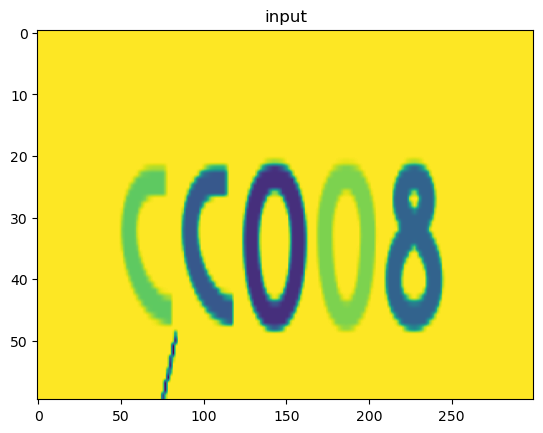

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


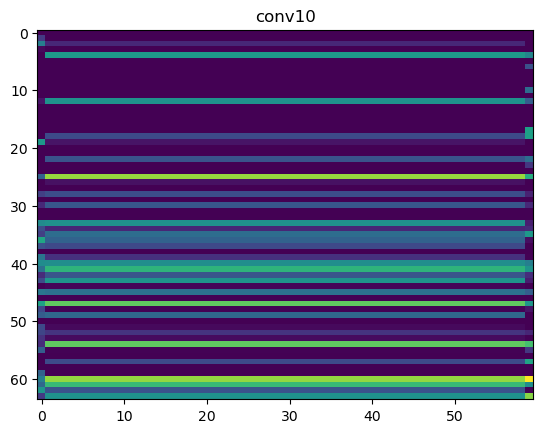

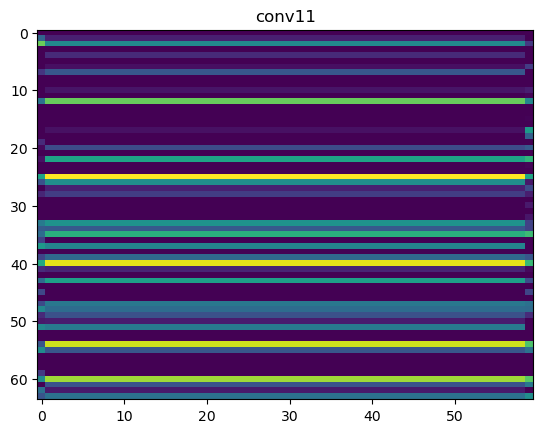

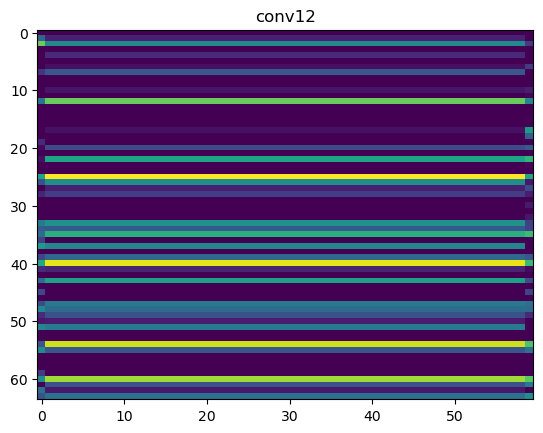

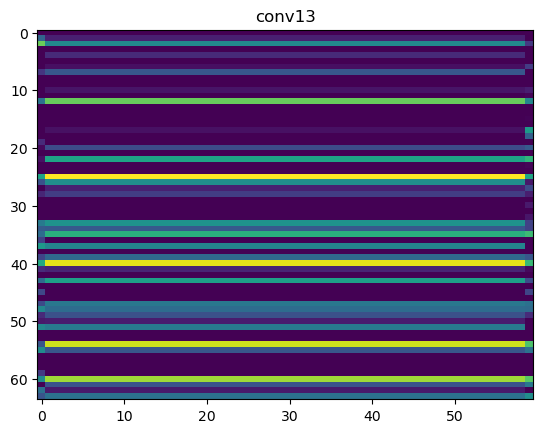

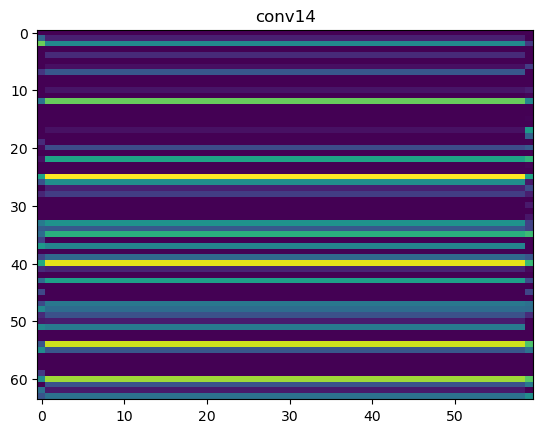

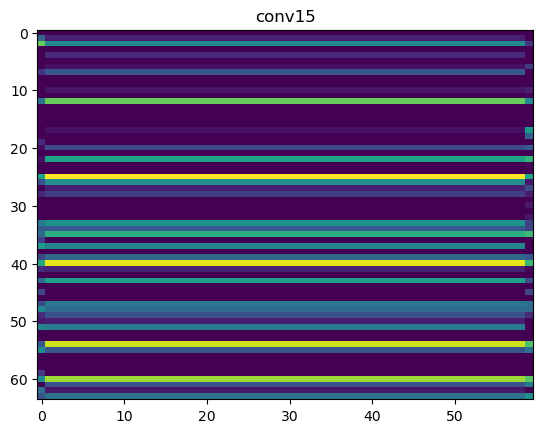

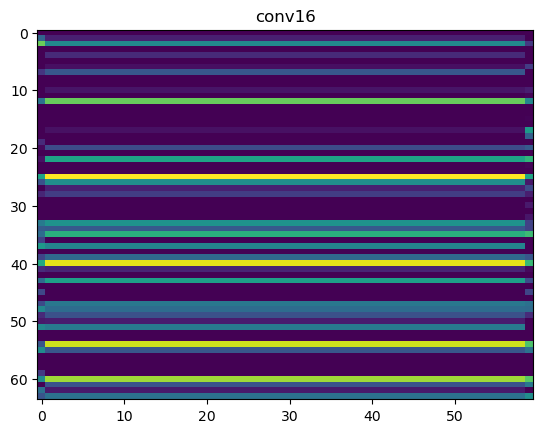

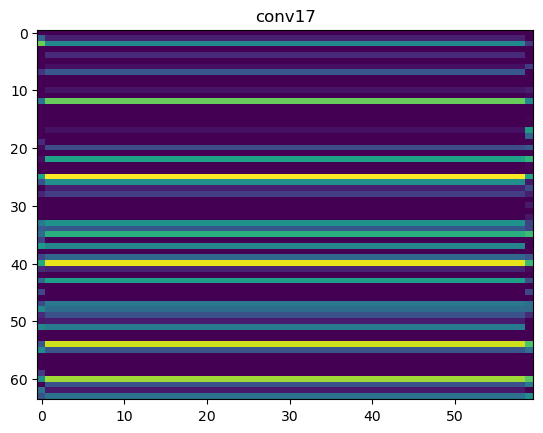

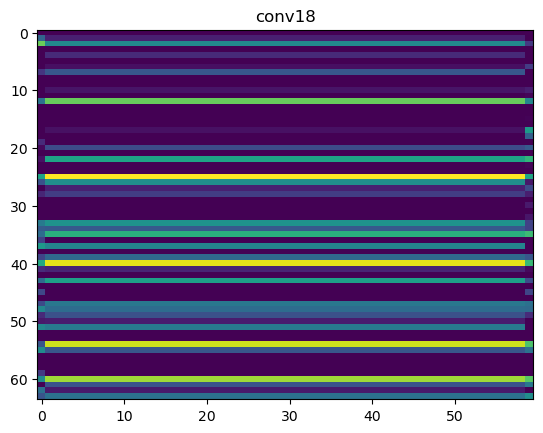

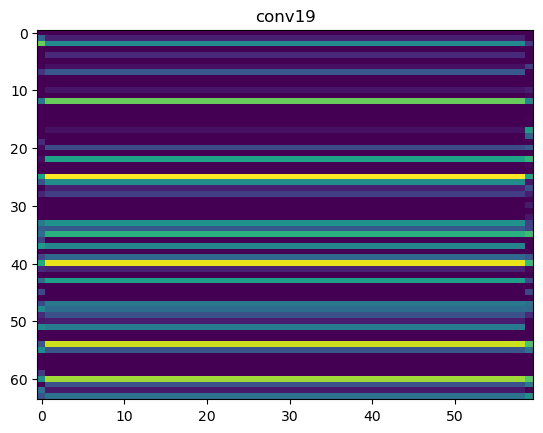

[INFO] True: 'cco08' vs Pred: ''
[INFO] True: 'zdfoj' vs Pred: ''
[INFO] True: 'yd9e' vs Pred: ''
[INFO] True: 'exicwf8' vs Pred: ''
[INFO] True: 'i0lmt69' vs Pred: ''
[INFO] True: 'nvqhrsga' vs Pred: ''
[INFO] True: 'aswhu3' vs Pred: ''
[INFO] True: 'dmx8md' vs Pred: ''
[INFO] True: 'vmii' vs Pred: ''
[INFO] True: 'b2z7d8ds' vs Pred: ''
[INFO] True: 'mvjjpt' vs Pred: ''
[INFO] True: '9a2xdo' vs Pred: ''
[INFO] True: 'nwhjcd1l' vs Pred: ''
[INFO] True: 'd9crqi1' vs Pred: ''
[INFO] True: 'rekoz3dv' vs Pred: ''
[INFO] True: 'xdxmvjhi' vs Pred: ''
[INFO] True: 'i9cdj0wk' vs Pred: ''
[INFO] True: 'qax34c8d' vs Pred: ''
[INFO] True: 'bgttx' vs Pred: ''
[INFO] True: 'usskt' vs Pred: ''
[INFO] Validation Accuracy: 0.0000
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - accuracy: 0.0010 - loss: 125.4507 - val_accuracy: 0.0000e+00 - val_loss: 82.9628
Epoch 2/30
[DEBUG] start ctc_loss
[DEBUG] shape: y_true (32, 37), y_pred (32, 37, 66)
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.0000e+00 - loss: 75

/opt/anaconda3/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


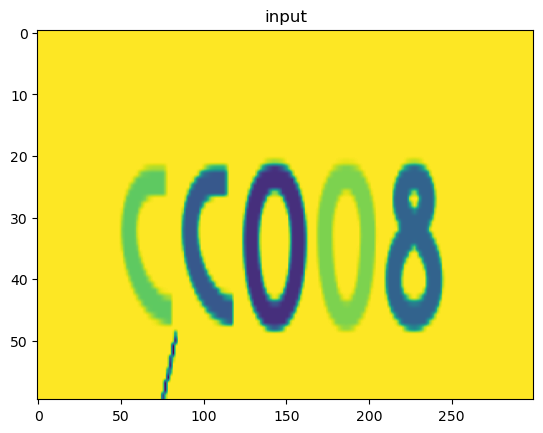

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


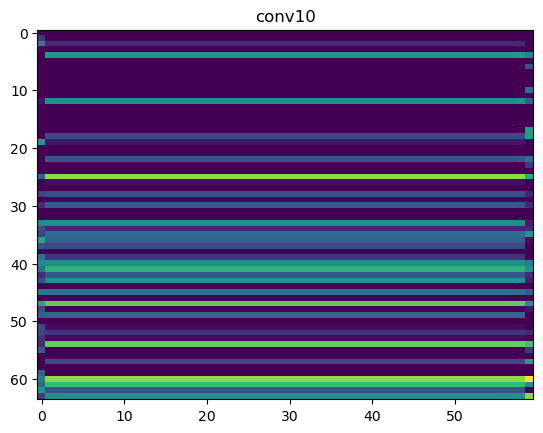

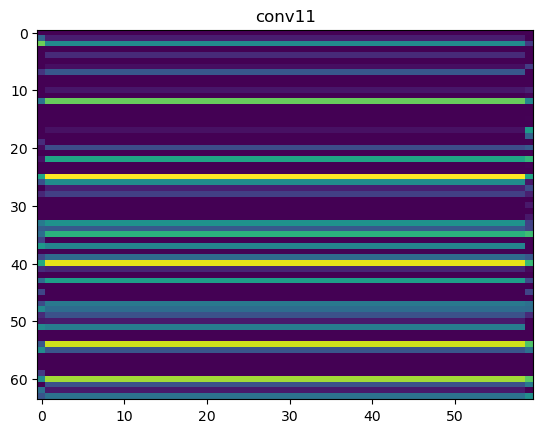

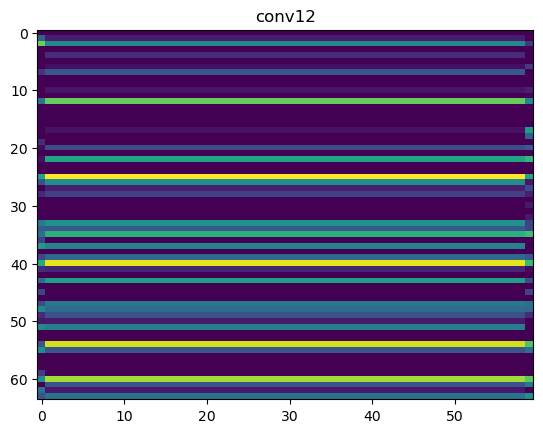

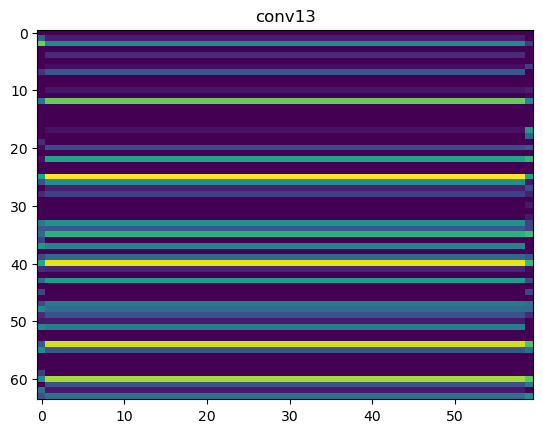

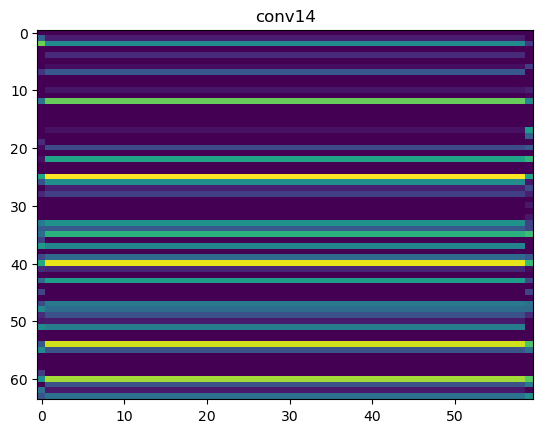

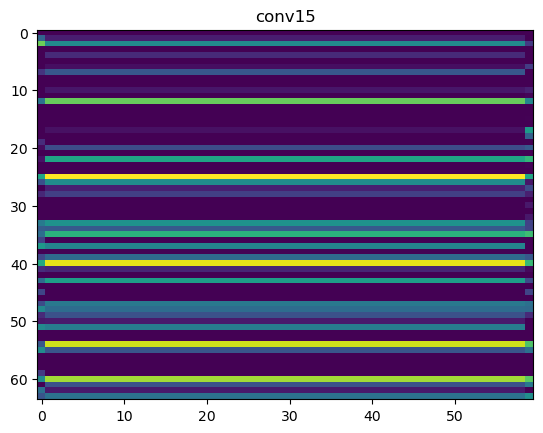

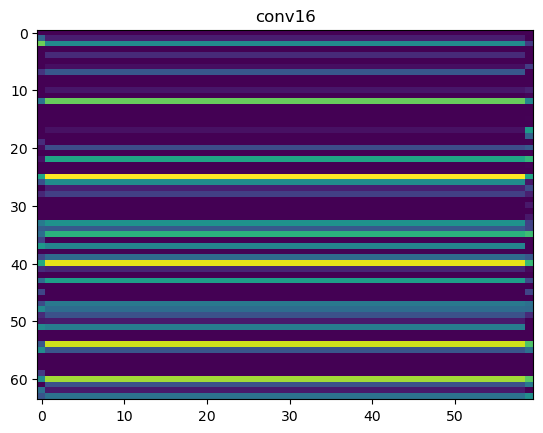

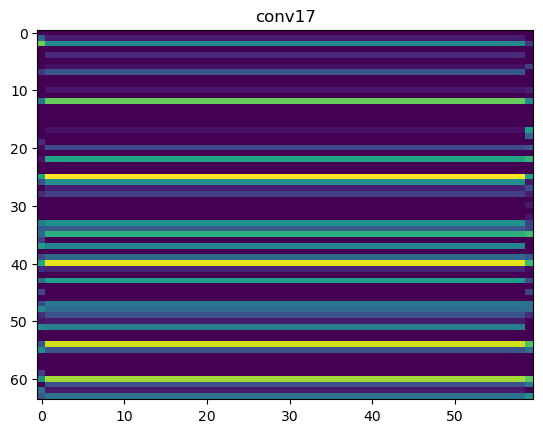

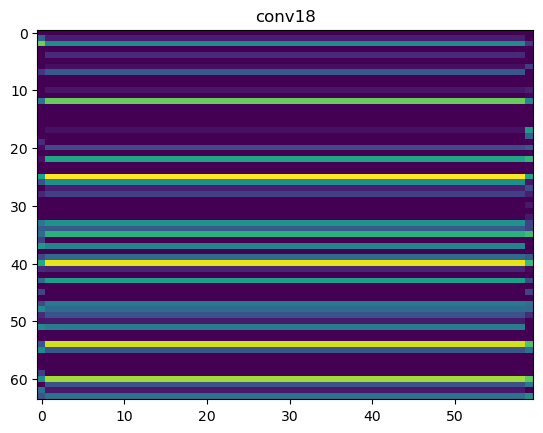

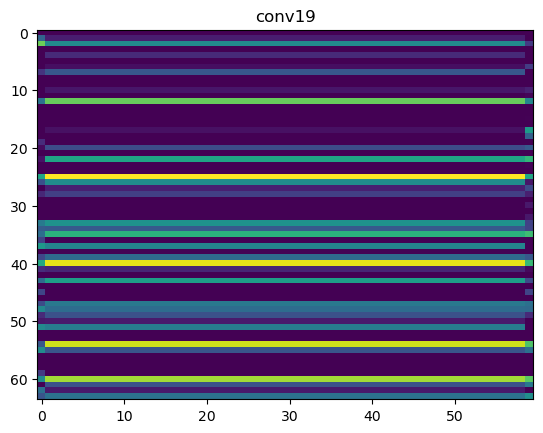

[INFO] True: 'cco08' vs Pred: ''
[INFO] True: 'zdfoj' vs Pred: ''
[INFO] True: 'yd9e' vs Pred: ''
[INFO] True: 'exicwf8' vs Pred: ''
[INFO] True: 'i0lmt69' vs Pred: ''
[INFO] True: 'nvqhrsga' vs Pred: ''
[INFO] True: 'aswhu3' vs Pred: ''
[INFO] True: 'dmx8md' vs Pred: ''
[INFO] True: 'vmii' vs Pred: ''
[INFO] True: 'b2z7d8ds' vs Pred: ''
[INFO] True: 'mvjjpt' vs Pred: ''
[INFO] True: '9a2xdo' vs Pred: ''
[INFO] True: 'nwhjcd1l' vs Pred: ''
[INFO] True: 'd9crqi1' vs Pred: ''
[INFO] True: 'rekoz3dv' vs Pred: ''
[INFO] True: 'xdxmvjhi' vs Pred: ''
[INFO] True: 'i9cdj0wk' vs Pred: ''
[INFO] True: 'qax34c8d' vs Pred: ''
[INFO] True: 'bgttx' vs Pred: ''
[INFO] True: 'usskt' vs Pred: ''
[INFO] Validation Accuracy: 0.0000
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - accuracy: 0.0000e+00 - loss: 65.8678 - val_accuracy: 0.0000e+00 - val_loss: 32.4178
Epoch 3/30
[DEBUG] start ctc_loss
[DEBUG] shape: y_true (32, 37), y_pred (32, 37, 66)
1/3 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.0000e+00 - loss: 

KeyboardInterrupt: 

In [892]:
if __name__ == '__main__':
    train()
    # predict()